Time Series Forecasting Project

In [1]:
!pip install -q torch captum statsmodels pmdarima scikit-learn
print(" Installation complete! Now run the next cell.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 re

In [2]:
!pip install --upgrade --force-reinstall numpy pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from captum.attr import IntegratedGradients
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

  Using cached numpy-2.4.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.4.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.4 MB)
Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.4 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Unins

 Using device: cpu


In [1]:
import numpy as np
import pandas as pd

# Generate RPS Dataset
print("Generating RPS dataset...")
n_samples = 2000
t = np.arange(n_samples)

# Components
trend = 200000 + 500 * t + 0.1 * t**2
seasonality = 15000 * np.sin(2 * np.pi * t / 365) + 8000 * np.sin(2 * np.pi * t / 90)
cycle = 25000 * np.sin(2 * np.pi * t / (365 * 6))

# Features
interest_rates = 4.5 + 2 * np.sin(2 * np.pi * t / 730) + np.random.normal(0, 0.3, n_samples)
interest_rates = np.clip(interest_rates, 2.0, 8.0)

employment_rate = 85 + 10 * np.sin(2 * np.pi * t / 1460) + np.random.normal(0, 2, n_samples)
employment_rate = np.clip(employment_rate, 75, 95)

housing_supply = 10000 + 20 * t + 500 * np.sin(2 * np.pi * t / 180) + np.random.normal(0, 300, n_samples)

gdp_growth = 2.5 + 1.5 * np.sin(2 * np.pi * t / 1095) + np.random.normal(0, 0.5, n_samples)

consumer_confidence = 100 + 15 * np.sin(2 * np.pi * t / 365) + np.random.normal(0, 5, n_samples)
consumer_confidence = np.clip(consumer_confidence, 70, 130)

# Calculate prices
feature_impact = (-3000 * (interest_rates - 4.5) +
                  800 * (employment_rate - 85) / 10 +
                  -0.5 * (housing_supply - 10000) +
                  2000 * gdp_growth +
                  150 * (consumer_confidence - 100))

ar_component = np.zeros(n_samples)
ar_component[0] = np.random.normal(0, 5000)
for i in range(1, n_samples):
    ar_component[i] = 0.7 * ar_component[i-1] + np.random.normal(0, 5000)

prices = trend + seasonality + cycle + feature_impact + ar_component
prices = np.maximum(prices, 100000)

# Create DataFrame
dates = pd.date_range(start='2018-01-01', periods=n_samples, freq='D')
df = pd.DataFrame({
    'date': dates, 'price': prices, 'interest_rate': interest_rates,
    'employment_rate': employment_rate, 'housing_supply': housing_supply,
    'gdp_growth': gdp_growth, 'consumer_confidence': consumer_confidence
})

print(f" Dataset created: {df.shape}")
print(df.head())

Generating RPS dataset...
 Dataset created: (2000, 7)
        date          price  interest_rate  employment_rate  housing_supply  \
0 2018-01-01  204630.295566       4.758344        85.509329    10629.711525   
1 2018-01-02  204214.070645       4.647386        85.816686     9904.803206   
2 2018-01-03  204221.142238       4.449752        86.742331     9426.521038   
3 2018-01-04  196495.020756       4.639158        86.105464    10102.859932   
4 2018-01-05  207741.305389       4.763051        87.724969    10902.273260   

   gdp_growth  consumer_confidence  
0    3.201210            97.086671  
1    2.489883           106.030159  
2    3.182793           109.414024  
3    2.811632            89.915061  
4    2.706574            93.207382  


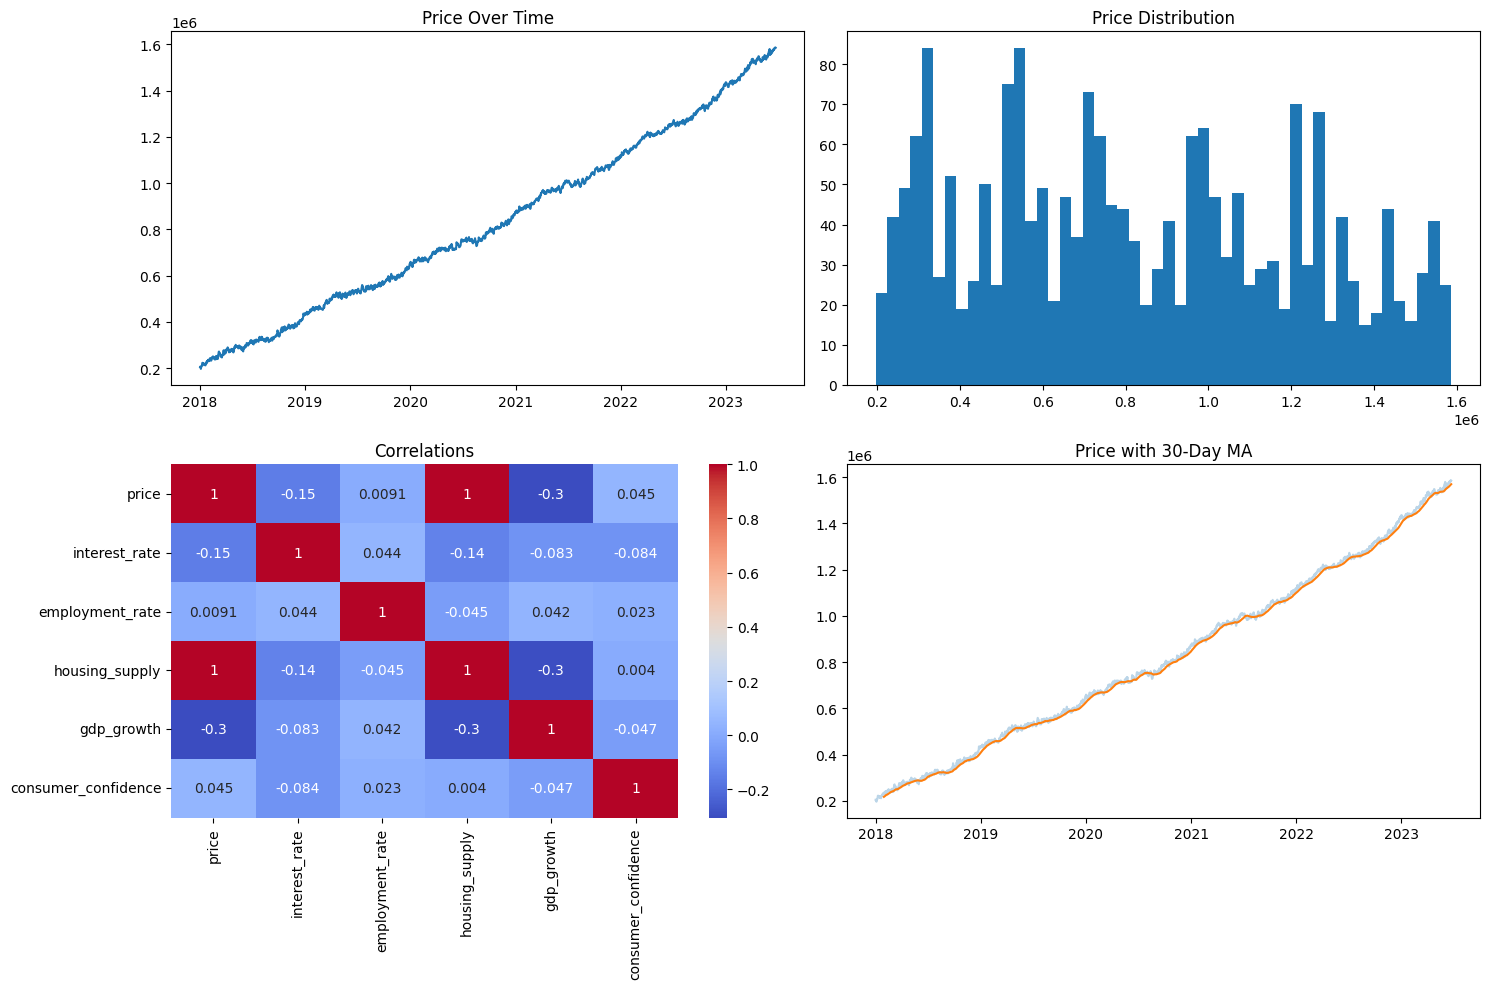

ADF p-value: 0.9988
Non-stationary


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns # Assuming sns is also needed for heatmap
from statsmodels.tsa.stattools import adfuller # Assuming adfuller is also needed

# Quick EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(df['date'], df['price'])
axes[0,0].set_title('Price Over Time')

axes[0,1].hist(df['price'], bins=50)
axes[0,1].set_title('Price Distribution')

corr = df.drop('date', axis=1).corr()
sns.heatmap(corr, annot=True, ax=axes[1,0], cmap='coolwarm')
axes[1,0].set_title('Correlations')

df['MA30'] = df['price'].rolling(30).mean()
axes[1,1].plot(df['date'], df['price'], alpha=0.3)
axes[1,1].plot(df['date'], df['MA30'])
axes[1,1].set_title('Price with 30-Day MA')

plt.tight_layout()
plt.show()

# Stationarity test
adf_result = adfuller(df['price'])
print(f"ADF p-value: {adf_result[1]:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Non-stationary")

In [3]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

class Preprocessor:
    def __init__(self):
        self.scalers = {}

    def preprocess(self, df, fit=True):
        df_proc = df.copy()

        # Create lag features
        for lag in [1, 7, 30]:
            df_proc[f'price_lag_{lag}'] = df_proc['price'].shift(lag)

        # Rolling features
        df_proc['rolling_mean_7'] = df_proc['price'].rolling(7).mean()
        df_proc['rolling_std_7'] = df_proc['price'].rolling(7).std()

        # Time features
        df_proc['day_of_week'] = df_proc['date'].dt.dayofweek
        df_proc['month'] = df_proc['date'].dt.month
        df_proc['day_sin'] = np.sin(2 * np.pi * df_proc['day_of_week'] / 7)
        df_proc['day_cos'] = np.cos(2 * np.pi * df_proc['day_of_week'] / 7)

        df_proc = df_proc.dropna()

        # Normalize
        date_col = df_proc['date']
        for col in df_proc.columns:
            if col != 'date':
                if fit:
                    scaler = StandardScaler()
                    df_proc[col] = scaler.fit_transform(df_proc[[col]])
                    self.scalers[col] = scaler
                else:
                    df_proc[col] = self.scalers[col].transform(df_proc[[col]])

        df_proc['date'] = date_col
        return df_proc

    def inverse_transform(self, values, feature='price'):
        return self.scalers[feature].inverse_transform(values.reshape(-1, 1)).flatten()

preprocessor = Preprocessor()
df_processed = preprocessor.preprocess(df, fit=True)

# Split data
n = len(df_processed)
train_df = df_processed.iloc[:int(n*0.7)]
val_df = df_processed.iloc[int(n*0.7):int(n*0.85)]
test_df = df_processed.iloc[int(n*0.85):]

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1379, Val: 295, Test: 296


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=30):
        self.seq_len = seq_len
        feature_cols = [c for c in df.columns if c not in ['date', 'price']]
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df['price'].values.astype(np.float32)

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.features[idx:idx+self.seq_len]),
                torch.FloatTensor([self.targets[idx+self.seq_len]]))

SEQ_LEN, BATCH_SIZE = 30, 32
train_dataset = TimeSeriesDataset(train_df, SEQ_LEN)
val_dataset = TimeSeriesDataset(val_df, SEQ_LEN)
test_dataset = TimeSeriesDataset(test_df, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

n_features = train_dataset.features.shape[1]
print(f"Features: {n_features}, Train batches: {len(train_loader)}")

Features: 15, Train batches: 43


In [7]:
import torch.nn as nn
import torch # Ensure torch is imported for torch.device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device here

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

lstm_model = LSTMModel(n_features).to(device)
print(f"Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

Parameters: 216,705


In [6]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter, patience = 0, 10

    print("Training...")
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                output = model(X)
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_state)
    return train_losses, val_losses

# Train LSTM
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader)

Training...
Epoch 10: Train=0.078836, Val=0.477469
Early stopping at epoch 17


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, layers=3, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*4, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

transformer_model = TransformerModel(n_features).to(device)
print(f"Parameters: {sum(p.numel() for p in transformer_model.parameters()):,}")

# Train Transformer
trans_train_losses, trans_val_losses = train_model(transformer_model, train_loader, val_loader, lr=0.0005)

Parameters: 605,185
Training...
Epoch 10: Train=0.493284, Val=1.813911
Early stopping at epoch 16


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, test_loader, preprocessor):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            predictions.extend(output.cpu().numpy())
            actuals.extend(y.cpu().numpy())

    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()

    # Inverse transform
    pred_original = preprocessor.inverse_transform(predictions, 'price')
    actual_original = preprocessor.inverse_transform(actuals, 'price')

    rmse = np.sqrt(mean_squared_error(actual_original, pred_original))
    mae = mean_absolute_error(actual_original, pred_original)
    r2 = r2_score(actual_original, pred_original)

    return {'predictions': pred_original, 'actuals': actual_original,
            'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate both models
lstm_results = evaluate_model(lstm_model, test_loader, preprocessor)
trans_results = evaluate_model(transformer_model, test_loader, preprocessor)

print("\nLSTM Results:")
print(f"  RMSE: ${lstm_results['rmse']:,.2f}")
print(f"  MAE: ${lstm_results['mae']:,.2f}")
print(f"  R²: {lstm_results['r2']:.4f}")

print("\nTransformer Results:")
print(f"  RMSE: ${trans_results['rmse']:,.2f}")
print(f"  MAE: ${trans_results['mae']:,.2f}")
print(f"  R²: {trans_results['r2']:.4f}")


LSTM Results:
  RMSE: $576,611.15
  MAE: $570,834.38
  R²: -49.3052

Transformer Results:
  RMSE: $542,405.80
  MAE: $536,278.50
  R²: -43.5139


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMAX Baseline
print("Training SARIMAX...")

train_price = preprocessor.inverse_transform(train_df['price'].values, 'price')
test_price = preprocessor.inverse_transform(test_df['price'].values, 'price')

model_sarimax = SARIMAX(train_price, order=(2,1,2), seasonal_order=(1,1,1,7))
results_sarimax = model_sarimax.fit(disp=False, maxiter=200)

n_forecast = len(test_price) - SEQ_LEN
forecast = results_sarimax.forecast(steps=n_forecast)
actual_aligned = test_price[SEQ_LEN:SEQ_LEN+n_forecast]

sarimax_rmse = np.sqrt(mean_squared_error(actual_aligned, forecast))
sarimax_mae = mean_absolute_error(actual_aligned, forecast)
sarimax_r2 = r2_score(actual_aligned, forecast)

print(f"\nSARIMAX Results:")
print(f"  RMSE: ${sarimax_rmse:,.2f}")
print(f"  MAE: ${sarimax_mae:,.2f}")
print(f"  R²: {sarimax_r2:.4f}")

Training SARIMAX...

SARIMAX Results:
  RMSE: $284,512.63
  MAE: $282,926.89
  R²: -11.2476



MODEL COMPARISON
      Model          RMSE           MAE         R²
       LSTM 576611.146004 570834.375000 -49.305229
Transformer 542405.795839 536278.500000 -43.513908
    SARIMAX 284512.628648 282926.892813 -11.247578


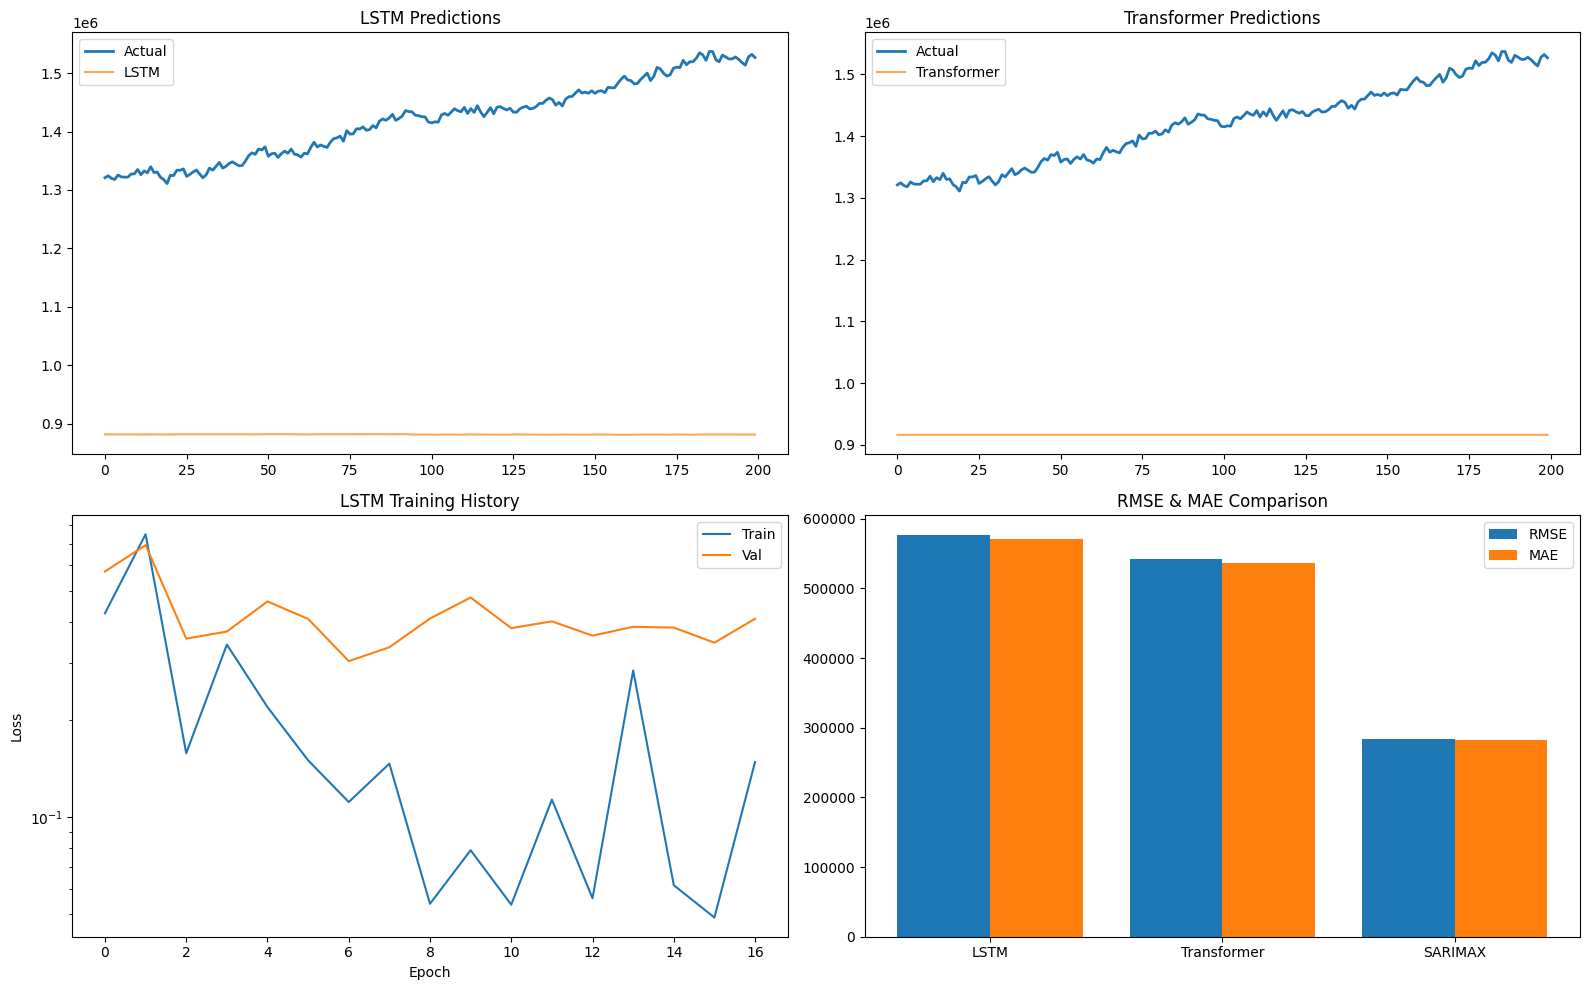

In [11]:
# Model Comparison
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'Transformer', 'SARIMAX'],
    'RMSE': [lstm_results['rmse'], trans_results['rmse'], sarimax_rmse],
    'MAE': [lstm_results['mae'], trans_results['mae'], sarimax_mae],
    'R²': [lstm_results['r2'], trans_results['r2'], sarimax_r2]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Predictions
n_plot = min(200, len(lstm_results['predictions']))
axes[0,0].plot(lstm_results['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0,0].plot(lstm_results['predictions'][:n_plot], label='LSTM', alpha=0.7)
axes[0,0].set_title('LSTM Predictions')
axes[0,0].legend()

axes[0,1].plot(trans_results['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0,1].plot(trans_results['predictions'][:n_plot], label='Transformer', alpha=0.7)
axes[0,1].set_title('Transformer Predictions')
axes[0,1].legend()

# Training history
axes[1,0].plot(lstm_train_losses, label='Train')
axes[1,0].plot(lstm_val_losses, label='Val')
axes[1,0].set_title('LSTM Training History')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].set_yscale('log')

# Metrics comparison
x = np.arange(len(comparison_df))
axes[1,1].bar(x - 0.2, comparison_df['RMSE'], 0.4, label='RMSE')
axes[1,1].bar(x + 0.2, comparison_df['MAE'], 0.4, label='MAE')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(comparison_df['Model'])
axes[1,1].set_title('RMSE & MAE Comparison')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Computing Integrated Gradients...


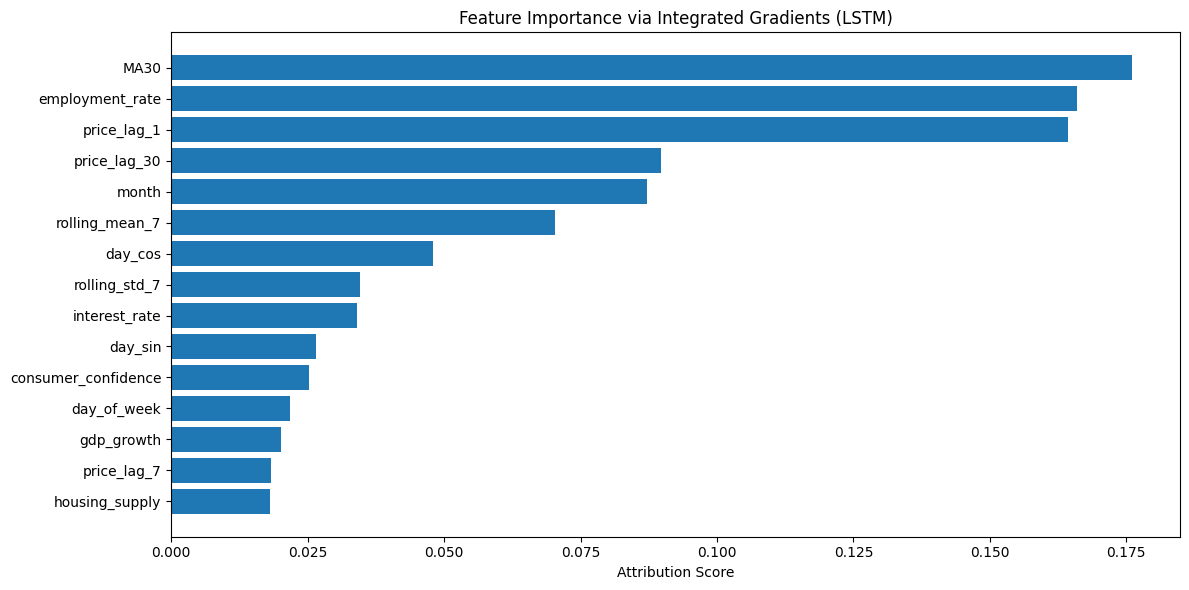


Top 5 Most Important Features:
  1. MA30: 0.1760
  2. employment_rate: 0.1659
  3. price_lag_1: 0.1644
  4. price_lag_30: 0.0897
  5. month: 0.0872


In [12]:
from captum.attr import IntegratedGradients

# Integrated Gradients for LSTM
print("Computing Integrated Gradients...")

ig = IntegratedGradients(lstm_model)

# Get sample batch
test_iter = iter(test_loader)
sample_x, sample_y = next(test_iter)
sample_x = sample_x[:5].to(device)  # Take 5 samples

# Compute attributions
baseline = torch.zeros_like(sample_x)
attributions = ig.attribute(sample_x, baseline)

# Average across samples and time
feature_importance = attributions.abs().mean(dim=(0,1)).cpu().numpy()
feature_importance = feature_importance / feature_importance.sum()

# Get feature names
feature_names = [c for c in train_df.columns if c not in ['date', 'price']]

# Plot
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Attribution Score')
plt.title('Feature Importance via Integrated Gradients (LSTM)')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
top_idx = sorted_idx[-5:][::-1]
for i, idx in enumerate(top_idx, 1):
    print(f"  {i}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

In [13]:
print("\n" + "="*80)
print("FINAL PROJECT SUMMARY REPORT")
print("="*80)

print("\n DATASET:")
print(f"  Total samples: 2000 days (~5.5 years)")
print(f"  Features: 6 exogenous + engineered features")
print(f"  Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}")

print("\n MODELS TRAINED:")
print("  1. LSTM (2 layers, 128 hidden units)")
print("  2. Transformer (3 layers, 8 attention heads)")
print("  3. SARIMAX (traditional baseline)")

print("\n PERFORMANCE:")
print(comparison_df.to_string(index=False))

best_model = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
print(f"\n Best Model: {best_model}")

improvement = (sarimax_rmse - comparison_df['RMSE'].min()) / sarimax_rmse * 100
print(f" Improvement over SARIMAX: {improvement:.2f}%")

print("\n PROJECT COMPLETE!")
print("="*80)

# Save results
comparison_df.to_csv('model_comparison.csv', index=False)
print("\n Results saved to 'model_comparison.csv'")


FINAL PROJECT SUMMARY REPORT

 DATASET:
  Total samples: 2000 days (~5.5 years)
  Features: 6 exogenous + engineered features
  Train/Val/Test: 1379/295/296

 MODELS TRAINED:
  1. LSTM (2 layers, 128 hidden units)
  2. Transformer (3 layers, 8 attention heads)
  3. SARIMAX (traditional baseline)

 PERFORMANCE:
      Model          RMSE           MAE         R²
       LSTM 576611.146004 570834.375000 -49.305229
Transformer 542405.795839 536278.500000 -43.513908
    SARIMAX 284512.628648 282926.892813 -11.247578

 Best Model: SARIMAX
 Improvement over SARIMAX: 0.00%

 PROJECT COMPLETE!

 Results saved to 'model_comparison.csv'
